In [634]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.neural_network import MLPClassifier

%matplotlib inline

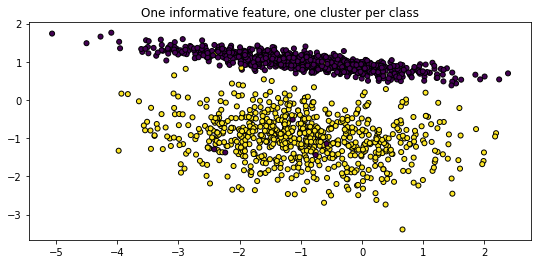

In [635]:
plt.figure(figsize=(9, 4))
plt.title("One informative feature, one cluster per class")
X, y = make_classification(n_samples=1500, n_features=2, n_classes=2,
                               n_redundant=0, n_informative=2, n_clusters_per_class=1)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=25, edgecolor='k')
plt.show()

In [636]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [1066]:
class MultiLayerPerceptronOld():
    
    def __init__(self, X, y, activation='sigmoid'):
        self.X = X
        self.y = np.array([y]).T
        
        # weights
        self._W1 = np.random.rand(X.shape[1], 10)
        self._W2 = np.random.rand(10, 1)
        # self._W3 = np.random.rand(25, 5)
        # self._W4 = np.random.rand(5, 1)
        
        # layers
        self._l0 = self.X
        self._l1 = np.zeros((self._l0.shape[1], self._W1.shape[1]))
        self._l2 = np.zeros((self._l1.shape[1], self._W2.shape[1]))
        # self._l3 = np.zeros((self._l2.shape[1], self._W3.shape[1]))
        # self._l4 = np.zeros((self._l3.shape[1], self._W4.shape[1]))
    
        if activation == 'sigmoid':
            self._activation = self._sigmoid
        else:
            self._activation = self._relu
    
    def _sigmoid(self, Z, deriv=False):
        if deriv == True:
            return Z * (1 - Z)
        return 1 / (1 + np.exp(-Z))
    
    def _relu(self, Z, deriv=False):
        if deriv == True:
            return np.where(Z > 0, 1, 0)
        return np.maximum(0, Z)

    def _bin_cross_entropy(self, Yh, Y):
        m = Y_hat.shape[1]
        cost = -1 / m * (np.dot(Y, np.log(Yh).T) + np.dot(1 - Y, np.log(1 - Yh).T))
        return np.sum(np.squeeze(cost))
    
    def _mse(self, Yh):
        return np.sum(Yh**2)
    
    def softmax(self, Z):
        e_x = np.exp(Z - np.max(Z))
        return e_x / e_x.sum(axis=0) # only difference
    
    def forward(self, Z):
        self._l0 = Z
        self._l1 = np.dot(self._l0, self._W1)
        self._a1 = self._activation(self._l1)
        self._l2 = np.dot(self._a1, self._W2)
        self._a2 = self._activation(self._l2)
        # self._l3 = np.dot(self._a2, self._W3)
        # self._a3 = self._activation(self._l3)
        # self._l4 = np.dot(self._a3, self._W4)
        # self._a4 = self._activation(self._l4)
        return self._a2
    
    def h_backprop(self, delta, weight, layer):
        error = np.dot(delta, weight.T)
        delta = error * self._activation(layer, deriv=True)
        return delta
    
    def backward(self, lr):
        Yh = self._a2 - self.y
        # error_l3 = - (np.divide(self.y, yh) - np.divide(1 - self.y, 1 - yh))
        delta_l2 = Yh * self._activation(self._a2, deriv=True)
        # delta_l3 = self.h_backprop(delta_l4, self._W4, self._a3)
        # delta_l2 = self.h_backprop(delta_l3, self._W3, self._a2)
        delta_l1 = self.h_backprop(delta_l2, self._W2, self._a1)
        
        self._W1 -= lr * self._l0.T.dot(delta_l1)
        self._W2 -= lr * self._a1.T.dot(delta_l2)
        # self._W3 -= lr * self._a2.T.dot(delta_l3)
        # self._W4 -= lr * self._a3.T.dot(delta_l4)
        return Yh
    
    def train(self, epochs=20000, lr=1e-5):
        error_step = []
        total_expected_error = 0
        for epoch in range(epochs):
            self.forward(self.X)
            Yh = self.backward(lr)
            total_error = self._mse(Yh)
            if np.abs(total_expected_error-total_error) < 1e-15:
                return np.array(error_step)
            total_expected_error = total_error
            error_step.append(total_error)    
        return np.array(error_step)
    
    def predict(self, Z):
        return self.forward(Z)

In [1246]:
class Layer:
    
    def __init__(self, name=1, inputs=1, outputs=1, activation='sigmoid'):
        self._name = name
        self.W = np.random.rand(inputs, outputs)
        self.B = np.random.rand(outputs, 1)
        self.A = np.zeros((self.W.shape[1], inputs))
        
        if activation == 'sigmoid':
            self._activation = self._sigmoid
        else:
            self._activation = self._relu
    
    def __str__(self):
        return f'Layer: {self._name}'
    
    def __repr__(self):
        return f'Layer: {self._name}'
    
    def _sigmoid(self, Z, deriv=False):
        if deriv == True:
            return Z * (1 - Z)
        return 1 / (1 + np.exp(-Z))
    
    def _relu(self, Z, deriv=False):
        if deriv == True:
            return np.where(Z > 0, 1, 0)
        return np.maximum(0, Z)

    def forward(self, Z):
        self.A = self._activation(np.dot(Z, self.W))
        return self.A
    
    def backward_last(self, E):
        return E * self._activation(self.A, deriv=True)
    
    def backward(self, delta, weights):
        error = np.dot(delta, weights.T)
        delta = error * self._activation(self.A, deriv=True)
        return delta
    
    
class MultiLayerPerceptron:
    
    def __init__(self, layers, X, y):
        self._layers = layers
        self._X = X
        self._y = np.array([y]).T
    
    def _mse(self, Z):
        return np.sum(Z**2)
    
    def train(self, epochs=5000, lr=1e-5):
        error_step = []
        total_expected_error = 0
        for epoch in range(epochs):
            # forward
            Z = self.predict(self._X)

            # backward
            E = Z - self._y  # error
            deltas = [self._layers[-1].backward_last(E)]
            for i, layer in enumerate(list(reversed(self._layers))[1:]):
                d = layer.backward(deltas[i], self._layers[len(self._layers)-(i+1)].W)
                deltas.append(d)
            
            # update weights
            last_layer = self._layers[0]
            last_layer.W -= lr * self._X.T.dot(deltas[-1])
            for delta, layer in zip(list(reversed(deltas))[1:], self._layers[1:]):
                layer.W -= lr * last_layer.A.T.dot(delta)
                last_layer = layer

            total_error = self._mse(E)
            if np.abs(total_expected_error-total_error) < 1e-15:
                return np.array(error_step)
            total_expected_error = total_error
            error_step.append(total_error)    
        return np.array(error_step)
        
    def predict(self, Z):
        for layer in self._layers:
            Z = layer.forward(Z)
        return Z

Acurácia: 49.78%


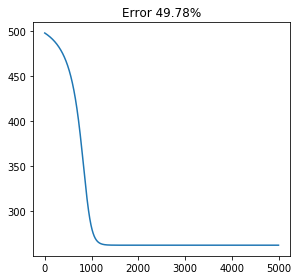

In [1250]:
final_error = None
better_acc = 0

bias, inputs = X_train.shape
layers = (
    Layer(1, inputs=inputs, outputs=100),
    Layer(2, inputs=100, outputs=10), 
#    Layer(3, inputs=5, outputs=10), 
#     Layer(4, inputs=20, outputs=10), 
    Layer(5, inputs=10, outputs=1), 
)

for _ in range(1):
    md = MultiLayerPerceptron(layers, X_train.copy(), y_train.copy())
    error = md.train()
    predYm = np.where(np.round(md.predict(X_test), 2).T[0] > .5, 1, 0)
    acc = np.round((np.sum(predYm == y_test) / len(y_test)) * 100, 2)
    if acc > better_acc:
        final_error = error
        better_acc = acc
    print(f'Acurácia: {acc}%')

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title(f'Error {better_acc}%')
plt.plot(range(len(final_error)), final_error)
plt.tight_layout()
plt.show()

In [1249]:
clf = MLPClassifier(max_iter=500)
clf.fit(X_train, y_train)
print(f'Acurácia: {np.round(clf.score(X_test, y_test) * 100, 2)}%')

Acurácia: 98.44%
